<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">FFNN and LSTM with All Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Setup

[Return to top](#Models)

In [1]:
# basic modules
import os
import sys
import time
import random
from datetime import timedelta, datetime
from pathlib import Path
from functools import reduce
import json
import random as rn
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures

# metrics & utilities
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score,
  roc_curve, RocCurveDisplay, auc, average_precision_score, precision_recall_curve,
  PrecisionRecallDisplay, precision_score, recall_score, f1_score, mean_squared_error
)
from sklearn.utils import resample, class_weight

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, losses, metrics, Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Input, Activation, Dropout, BatchNormalization,
    GaussianNoise, Flatten, LSTM, Concatenate, Embedding, Reshape)
from tensorflow.keras.optimizers import SGD, Adam, Nadam, Adagrad, RMSprop
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
base_path = "/content/drive/MyDrive/Colab Notebooks"
sys.path.append(base_path)

In [4]:
import utility_functions as utl

# TensorFlow Setup

[Return to top](#Models)

In [5]:
# set pseudo-random number seeds
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
random.seed(109)

In [6]:
tf.__version__

'2.15.0'

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 15 22:02:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10.
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [10]:
# read in data
all_features_df = pd.read_csv(base_path + "/nba_team_matchups_all_rolling_stats_merged_2021_2024_r10.csv")
all_features_df.head()

,GAME_ID,GAME_RESULT,TOTAL_PTS,PLUS_MINUS,HOME_TEAM_NAME,SEASON_ID,GAME_DATE,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,...,ROLL_AWAY_PASS,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT
0,22100002,0,235,-7.0,Los Angeles Lakers,2021-22,2021-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22100001,1,231,23.0,Milwaukee Bucks,2021-22,2021-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22100007,1,253,11.0,Memphis Grizzlies,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22100008,1,230,18.0,Minnesota Timberwolves,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22100009,0,214,-20.0,New Orleans Pelicans,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data=all_features_df,
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax',
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [12]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

total_ngames = season_22_ngames + season_23_ngames + season_24_ngames

In [13]:
pts_all_features.shape

(3058, 249)

In [14]:
pts_all_features.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,...,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745455,0.521739,0.248120,0.783784,0.769231,0.551570,0.731293,0.954774,0.942623,0.534979,...,0.666667,0.730769,0.583815,0.409091,0.130435,0.840909,0.611111,0.423077,1.000000,185
2021-10-23,0.000000,0.000000,0.624060,0.000000,0.076923,0.372197,0.000000,0.552764,0.573770,0.438272,...,0.000000,0.461538,0.000000,0.363636,0.413043,0.286364,0.166667,0.269231,0.439904,198
2021-10-23,0.690909,0.652174,0.473684,0.788288,0.461538,0.417040,0.465986,0.703518,0.573770,0.720165,...,0.266667,0.230769,0.601156,0.681818,0.391304,0.854545,0.055556,0.423077,0.000000,239
2021-10-23,0.727273,0.826087,0.661654,0.860360,0.538462,0.192825,0.772109,0.351759,0.409836,0.314815,...,0.400000,0.269231,0.760116,0.136364,0.326087,0.000000,0.500000,0.346154,0.963942,232
2021-10-24,0.745455,0.782609,0.548872,0.882883,0.846154,0.551570,0.819728,0.301508,0.245902,0.559671,...,0.200000,0.346154,0.367052,1.000000,1.000000,0.500000,0.777778,0.730769,0.725962,204


# Helper Functions

[Return to top](#Models)

In [17]:
def prepare_data_for_models(df, outcome_name, num_test_samples):
    """
    Prepare data for models, including feature/target split, scaling,
    and handling different outcome names.

    Args:
    - df: DataFrame containing both features and target.
    - outcome_name: Name of the target variable column in the DataFrame.
    - num_test_samples: Number of observations to include in the test set.

    Returns:
    - X_train, y_train: Original training features and target.
    - X_test, y_test: Original test features and target.
    - target_scaler: Scaler object for inverse transformation of predictions.
    """
    # Split into features and target based on outcome_name
    X = df.drop(outcome_name, axis=1)
    y = df[outcome_name]

    # Split into training and test sets
    X_train = X.iloc[:-num_test_samples]
    y_train_orig = y.iloc[:-num_test_samples]
    X_test = X.iloc[-num_test_samples:]
    y_test_orig = y.iloc[-num_test_samples:]

    # Scale the target variable
    target_scaler = MinMaxScaler()
    y_train = target_scaler.fit_transform(y_train_orig.to_numpy().reshape(-1, 1))
    y_test = target_scaler.transform(y_test_orig.to_numpy().reshape(-1, 1))

    return X_train, y_train, X_test, y_test, target_scaler

# Split Data into Train and Test Sets

[Return to top](#Models)

## Total Points

[Return to top](#Models)

In [18]:
X_train_pts, y_train_pts, X_test_pts, y_test_pts, \
scaler_pts = prepare_data_for_models(
    df=pts_all_features,
    outcome_name="TOTAL_PTS",
    num_test_samples=season_24_ngames
    )

# check the shapes
print(X_train_pts.shape), print(y_train_pts.shape), print(X_test_pts.shape), print(y_test_pts.shape)

(2367, 248)
(2367, 1)
(691, 248)
(691, 1) 

(2357, 10, 248)
(2357, 1)
(681, 10, 248)
(681, 1)


(None, None, None, None)

## Plus / Minus

[Return to top](#Models)

In [19]:
X_train_pm, y_train_pm, X_test_pm, y_test_pm, \
scaler_pm = prepare_data_for_models(
    df=pm_all_features,
    outcome_name="PLUS_MINUS",
    num_test_samples=season_24_ngames
    )

# check the shapes
print(X_train_pm.shape), print(y_train_pm.shape), print(X_test_pm.shape), print(y_test_pm.shape)

(2367, 248)
(2367, 1)
(691, 248)
(691, 1) 

(2357, 10, 248)
(2357, 1)
(681, 10, 248)
(681, 1)


(None, None, None, None)

## Game Winner

[Return to top](#Models)

In [20]:
X_train_res, y_train_res, X_test_res, y_test_res, \
scaler_res = prepare_data_for_models(
    df=res_all_features,
    outcome_name="GAME_RESULT",
    num_test_samples=season_24_ngames
    )

# check the shapes
print(X_train_res.shape), print(y_train_res.shape), print(X_test_res.shape), print(y_test_res.shape)

(2367, 248)
(2367, 1)
(691, 248)
(691, 1) 

(2357, 10, 248)
(2357, 1)
(681, 10, 248)
(681, 1)


(None, None, None, None)

# FFNN Training

[Return to top](#Models)

## Points Total

[Return to top](#Models)

In [ ]:
input_shape = (X_train_pts.shape[1],)

# inputs
inputs = Input(shape=input_shape)

x = Dense(units=512, activation='linear')(inputs) # kernel_regularizer=l2(0.001)
#x = Dropout(rate=0.1)(x)

x = Dense(units=64, activation='linear')(x)
#x = Dropout(rate=0.1)(x)

# Output layer for regression
outputs = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Model summary to verify architecture
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 248)]             0         
                                                                 
 dense_62 (Dense)            (None, 512)               127488    
                                                                 
 dense_63 (Dense)            (None, 64)                32832     
                                                                 
 dense_64 (Dense)            (None, 1)                 65        
                                                                 
Total params: 160385 (626.50 KB)
Trainable params: 160385 (626.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='best_FFNN_pts.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# For classification, 'binary_crossentropy' (binary) or 'categorical_crossentropy' (multiclass)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

history = model.fit(
    X_train_pts,
    y_train_pts,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 95.3676 - val_loss: 0.3563 - lr: 0.0100
Epoch 2/200
48/60 [=======================>......] - ETA: 0s - loss: 0.0789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0144 - lr: 0.0100
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0156 - lr: 0.0100
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0143 - lr: 0.0100
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0134 - lr: 0.0100
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0127 - lr: 0.0100
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.0129 - lr: 0.0100
Epoch 8/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.0123 - lr: 0.0100
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0121 - lr: 0.0100
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.0131 - lr: 0.0100
Epo

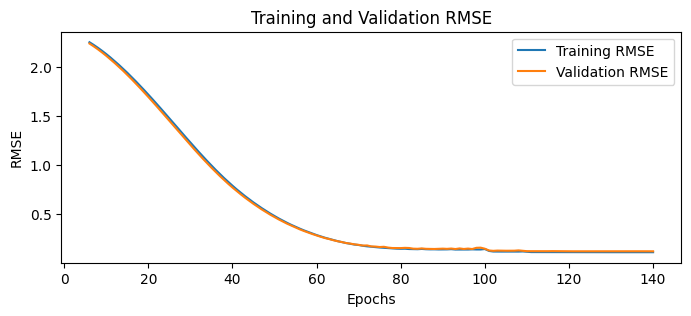

In [ ]:
# Assume `history` is the object returned by `model.fit()`
mse = history.history['loss']
val_mse = history.history['val_loss']

# Calculate RMSE
rmse = np.sqrt(mse)
val_rmse = np.sqrt(val_mse)

epochs = range(1, len(rmse) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], rmse[5:], label='Training RMSE')
plt.plot(epochs[5:], val_rmse[5:], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Predicting the target values for the test set
test_predictions_norm_pts = model.predict(X_test_pts)  # These predictions are in the scaled form

# need to back transform predicted y
test_predictions_pts = scaler_pts.inverse_transform(test_predictions_norm_pts)  # Inverse transform to original scale

# need to back transform true y
y_test_original_pts = scaler_pts.inverse_transform(y_test_pts)  # Inverse transform to original scale

# RMSE on original scale
rmse_pts = mean_squared_error(y_test_original_pts, test_predictions_pts, squared=False)
print(f'RMSE: {rmse_pts:.2f}')

22/22 [==============================] - 0s 1ms/step
RMSE: 18.98


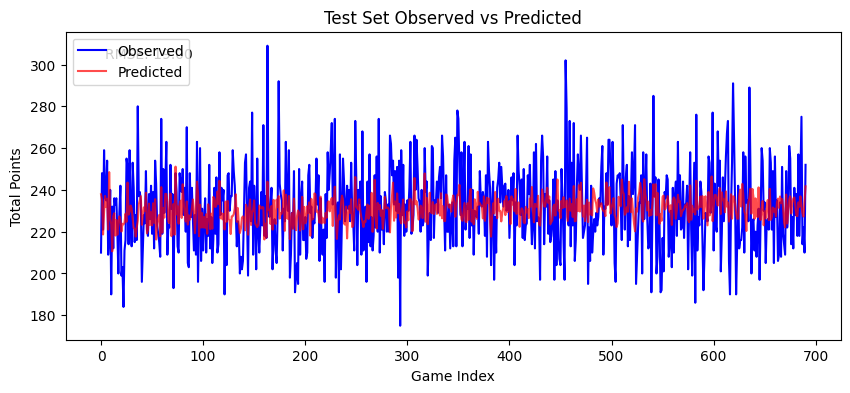

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_original_pts, label='Observed', color='blue')
plt.plot(test_predictions_pts.flatten(), label='Predicted', color='red', alpha=0.7)
plt.title('Test Set Observed vs Predicted')
plt.xlabel('Game Index')
plt.ylabel('Total Points')
plt.text(0.05, 0.95, f'RMSE: {rmse_pts:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.legend()
plt.show()

## Plus / Minus

[Return to top](#Models)

In [ ]:
input_shape = (X_train_pm.shape[1],)

# inputs
inputs = Input(shape=input_shape)

x = Dense(units=512, activation='linear')(inputs) # kernel_regularizer=l2(0.001)
#x = Dropout(rate=0.1)(x)

x = Dense(units=64, activation='linear')(x)
#x = Dropout(rate=0.5)(x)

#x = Dense(units=32, activation='linear')(x)
#x = Dropout(rate=0.2)(x)

# Output layer for regression
outputs = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Model summary to verify architecture
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 248)]             0         
                                                                 
 dense_59 (Dense)            (None, 512)               127488    
                                                                 
 dense_60 (Dense)            (None, 64)                32832     
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 160385 (626.50 KB)
Trainable params: 160385 (626.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='best_FFNN_pm.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# For classification, 'binary_crossentropy' (binary) or 'categorical_crossentropy' (multiclass)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

history = model.fit(
    X_train_pm,
    y_train_pm,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 144.3576 - val_loss: 0.5689 - lr: 0.0100
Epoch 2/200
45/60 [=====================>........] - ETA: 0s - loss: 0.1346

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.0221 - lr: 0.0100
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0227 - lr: 0.0100
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0189 - lr: 0.0100
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.0171 - lr: 0.0100
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0156 - lr: 0.0100
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0153 - lr: 0.0100
Epoch 8/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0143 - lr: 0.0100
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0131 - lr: 0.0100
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0126 - lr: 0.0100
Epo

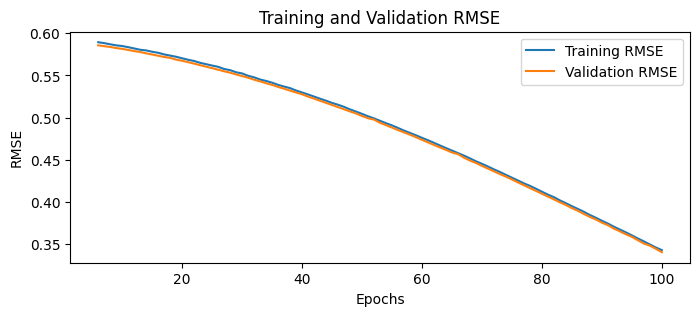

In [ ]:
# Assume `history` is the object returned by `model.fit()`
mse = history.history['loss']
val_mse = history.history['val_loss']

# Calculate RMSE
rmse = np.sqrt(mse)
val_rmse = np.sqrt(val_mse)

epochs = range(1, len(rmse) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], rmse[5:], label='Training RMSE')
plt.plot(epochs[5:], val_rmse[5:], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Predicting the target values for the test set
test_predictions_norm_pm = model.predict(X_test_pm)  # These predictions are in the scaled form

# need to back transform predicted y
test_predictions_pm = scaler_pm.inverse_transform(test_predictions_norm_pm)  # Inverse transform to original scale

# need to back transform true y
y_test_original_pm = scaler_pm.inverse_transform(y_test_pm)  # Inverse transform to original scale

# RMSE on original scale
rmse_pm = mean_squared_error(y_test_original_pm, test_predictions_pm, squared=False)
print(f'RMSE: {rmse_pm:.2f}')

22/22 [==============================] - 0s 1ms/step
RMSE: 14.30


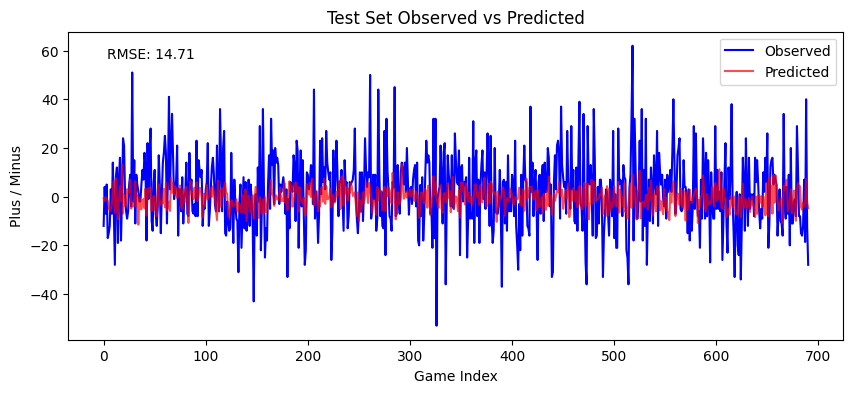

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_original_pm, label='Observed', color='blue')
plt.plot(test_predictions_pm.flatten(), label='Predicted', color='red', alpha=0.7)
plt.title('Test Set Observed vs Predicted')
plt.xlabel('Game Index')
plt.ylabel('Plus / Minus')
plt.text(0.05, 0.95, f'RMSE: {rmse_pm:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.legend()
plt.show()

## Game Winner

[Return to top](#Models)

In [20]:
# BEST AND SIMPLEST ARCHITECTURE

input_shape = (X_train_res.shape[1],)

# inputs
inputs = Input(shape=input_shape)

x = Dense(units=512, activation='linear')(inputs)
x = Dropout(rate=0.1)(x)

#x = Dense(units=256, activation='linear')(x)
#x = Dropout(rate=0.1)(x)

x = Dense(units=128, activation='linear')(x)
x = Dropout(rate=0.1)(x)

x = Dense(units=32, activation='linear')(x)
x = Dropout(rate=0.1)(x)

# Output layer for regression
# For classification, you might use activation='sigmoid' (binary) or 'softmax' (multiclass) and adjust units accordingly
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Model summary to verify architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 248)]             0         
                                                                 
 dense (Dense)               (None, 512)               127488    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [127]:
input_shape = (X_train_res.shape[1],)

# inputs
inputs = Input(shape=input_shape)

x = Dense(units=512, activation='linear')(inputs)
x = Dropout(rate=0.1)(x)

x = Dense(units=256, activation='linear')(x)
x = Dropout(rate=0.1)(x)

x = Dense(units=128, activation='linear')(x)
x = Dropout(rate=0.1)(x)

x = Dense(units=32, activation='linear')(x)
x = Dropout(rate=0.1)(x)

# Output layer for regression
# For classification, you might use activation='sigmoid' (binary) or 'softmax' (multiclass) and adjust units accordingly
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Model summary to verify architecture
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 248)]             0         
                                                                 
 dense_43 (Dense)            (None, 512)               127488    
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0  

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/best_FFNN_res2.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# For classification, 'binary_crossentropy' (binary) or 'categorical_crossentropy' (multiclass)
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy') # Nadam

history = model.fit(
    X_train_res,
    y_train_res,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

Epoch 1/100
59/60 [============================>.] - ETA: 0s - loss: 4.2837

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 2s 15ms/step - loss: 4.2744 - val_loss: 0.6906 - lr: 0.0100
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.7088 - val_loss: 0.6666 - lr: 0.0100
Epoch 3/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7071 - val_loss: 0.6616 - lr: 0.0100
Epoch 4/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7204 - val_loss: 0.6618 - lr: 0.0100
Epoch 5/100
60/60 [==============================] - 0s 5ms/step - loss: 0.7091 - val_loss: 0.6596 - lr: 0.0100
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6826 - val_loss: 0.6586 - lr: 0.0100
Epoch 7/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6454 - lr: 0.0100
Epoch 8/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6815 - val_loss: 0.6619 - lr: 0.0100
Epoch 9/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6823 - val_loss: 0.6830 - lr: 0.0100
Epo

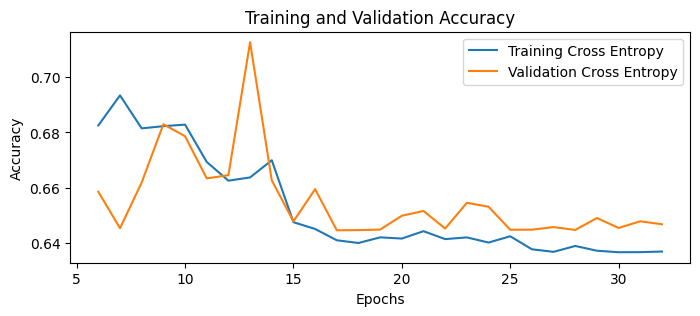

In [22]:
# Assume `history` is the object returned by `model.fit()`
xent = history.history['loss']
val_xent = history.history['val_loss']

epochs = range(1, len(xent) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], xent[5:], label='Training Cross Entropy')
plt.plot(epochs[5:], val_xent[5:], label='Validation Cross Entropy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Predicting the target values for the test set
test_predictions_res = model.predict(X_test_res)

# binary predictions
binary_predictions_res = np.where(test_predictions_res > 0.5, 1, 0)

# Accuracy
acc_res = accuracy_score(y_test_res, binary_predictions_res)
print(f'Accuracy: {acc_res:.2f}')

# F1-score
f1_res = f1_score(y_test_res, binary_predictions_res)
print(f'F1 Score: {f1_res:.2f}')

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.67
F1 Score: 0.72


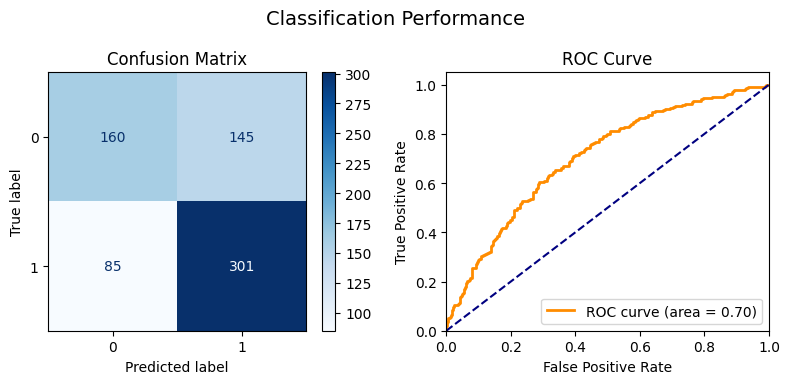

In [24]:
utl.plot_classification_performance(y_test_res, test_predictions_res, binary_predictions_res)

### Predictions

In [25]:
# Predict on test data
predictions = model.predict(X_test_res)

22/22 [==============================] - 0s 2ms/step


In [35]:
# add predictions to test set observations
test_set_obs['GAME_WINNER_PROBS'] = predictions.ravel()

In [36]:
test_set_obs

,SEASON_ID,GAME_ID,GAME_DATE,HOME_TEAM_NAME,AWAY_TEAM_NAME,GAME_WINNER_PROBS
2461,2023-24,22300077,2023-10-27,Charlotte Hornets,Detroit Pistons,0.607733
2464,2023-24,22300083,2023-10-27,San Antonio Spurs,Houston Rockets,0.656586
2472,2023-24,22300092,2023-10-28,Toronto Raptors,Philadelphia 76ers,0.614585
2478,2023-24,22300100,2023-10-29,Sacramento Kings,Los Angeles Lakers,0.550771
2479,2023-24,22300097,2023-10-29,Milwaukee Bucks,Atlanta Hawks,0.572223
...,...,...,...,...,...,...
3167,2023-24,22300699,2024-02-03,Atlanta Hawks,Golden State Warriors,0.485986
3168,2023-24,22300707,2024-02-04,Charlotte Hornets,Indiana Pacers,0.287340
3169,2023-24,22300706,2024-02-04,Boston Celtics,Memphis Grizzlies,0.676874
3170,2023-24,22300704,2024-02-04,Detroit Pistons,Orlando Magic,0.316086


In [37]:
test_set_obs.to_csv(base_path + '/FFNN_preds_all_features_res.csv', index=False)

### Shapley Values

In [24]:
def load_and_scale_data(input_data, seasons_to_keep, training_season, feature_prefixes,
                        scaler_type='minmax', scale_target=False, csv_out=False, output_path=None):
    """
    Loads data from a specified file, filters for specific seasons, scales the features (and optionally the target),
    using only the training data for scaler fitting, and applies this scaling across specified seasons.

    Parameters:
    - input_data (str or pd.DataFrame): Either the file path to the CSV containing the data or a pandas DataFrame.
    - seasons_to_keep (list): A list of SEASON_IDs to include in the analysis.
    - training_season (str): The season that the scaler should be fitted on.
    - feature_prefixes (list): A list of prefixes to identify feature names.
    - scaler_type (str): The type of scaler to use for feature scaling ('minmax' or 'standard').
    - scale_target (bool): Whether to scale the target variable(s) alongside the features.
    - csv_out(bool): Whether to return csv files with the missing / non-missing observations meta-data
    - output_path (str, optional): Relative file path for the csv files.

    Returns:
    - Tuple of pd.DataFrame: Scaled DataFrames for features (and targets if `scale_target` is True) for each target variable.
      Specifically returns DataFrames for TOTAL_PTS, PLUS_MINUS, and GAME_RESULT targets.
    """
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    # load the dataset
    if isinstance(input_data, str):
        df = pd.read_csv(input_data)
    elif isinstance(input_data, pd.DataFrame):
        df = input_data
    else:
        raise ValueError("input_data must be a pandas DataFrame or a file path as a string.")

    # set 'GAME_DATE' to datetime
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # filter the DataFrame for the specified seasons
    df_filtered = df[df['SEASON_ID'].isin(seasons_to_keep)]

    # initialize the scaler
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("scaler must be either 'minmax' or 'standard'")

    # filter column names that start with any of the prefixes in feature_prefixes
    feature_names = [col for col in df_filtered.columns if any(col.startswith(prefix) for prefix in feature_prefixes)]

    # identify rows with missing values in any of the feature_names and extract non-statistical data
    missing_features_rows = df_filtered[df_filtered[feature_names].isnull().any(axis=1)]
    dropped_obs_data = missing_features_rows[['SEASON_ID', 'GAME_ID', 'GAME_DATE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']]

    # identify rows with no missing values in any of the feature_names and extract non-statistical data
    no_missing_features_rows = df_filtered[~df_filtered[feature_names].isnull().any(axis=1)]
    kept_obs_data = no_missing_features_rows[['SEASON_ID', 'GAME_ID', 'GAME_DATE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']]

    # extract non-statistical data for non-missing rows in the test set (season 2023-24)
    kept_test_set_obs = kept_obs_data[kept_obs_data['SEASON_ID'] == '2023-24']

    if csv_out and (output_path is not None):
        dropped_obs_data.to_csv(f"{output_path}nba_rolling_box_scores_dropped_observations.csv", index=False)
        kept_obs_data.to_csv(f"{output_path}nba_rolling_box_scores_kept_observations.csv", index=False)
        kept_test_set_obs.to_csv(f"{output_path}nba_rolling_box_scores_test_set_observations.csv", index=False)

    # drop rows with missing values from df_filtered
    df_filtered = df_filtered.dropna(subset=feature_names)

    # set GAME_DATE as the index
    df_filtered.set_index('GAME_DATE', inplace=True)

    # fit the scaler on features from the training season only
    training_features = df_filtered[df_filtered['SEASON_ID'] == training_season][feature_names]
    scaler.fit(training_features)

    # transform the feature columns for the entire filtered dataset
    df_filtered[feature_names] = scaler.transform(df_filtered[feature_names])

    # prepare to store scaled data for each target
    pts_scaled_df, pm_scaled_df, res_scaled_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # apply scaling to features (and optionally targets) for all specified target columns
    for target_col in ['TOTAL_PTS', 'PLUS_MINUS', 'GAME_RESULT']:

        # optionally scale target
        if scale_target:
            df_filtered[target_col] = scaler.transform(df_filtered[[target_col]])

        # select and assign scaled data for each target_col
        if target_col == 'TOTAL_PTS':
            pts_scaled_df = df_filtered[feature_names + [target_col]].copy()
        elif target_col == 'PLUS_MINUS':
            pm_scaled_df = df_filtered[feature_names + [target_col]].copy()
        elif target_col == 'GAME_RESULT':
            res_scaled_df = df_filtered[feature_names + [target_col]].copy()

    # print the number of unique games for each season in the filtered data
    for season_id in seasons_to_keep:
        num_games = df_filtered[df_filtered['SEASON_ID'] == season_id]['GAME_ID'].nunique()
        print(f"Season {season_id}: {num_games} games")

    # print total number of unique games in the filtered data
    print(f"Total number of games across sampled seasons: {df_filtered['GAME_ID'].nunique()} games")

    return pts_scaled_df, pm_scaled_df, res_scaled_df, kept_test_set_obs

In [25]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = load_and_scale_data(
    input_data=base_path + '/nba_team_matchups_all_rolling_stats_merged_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax',
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [26]:
# extract the test set
res_all_features_test_set = res_all_features[res_all_features.index >= "2023-10-01"]

# drop the outcome
res_all_features_test_set = res_all_features_test_set.drop('GAME_RESULT', axis=1)

# get features
features = res_all_features_test_set.columns

# Rename features: replace underscores with spaces and convert to title case
renamed_features = [feature.replace('_', ' ').title() for feature in features]

# Create a mapping for old names to new names
rename_mapping = dict(zip(features, renamed_features))

# Use the mapping to rename columns in the DataFrame
res_all_features_test_set_renamed = res_all_features_test_set.rename(columns=rename_mapping)

In [27]:
res_all_features_test_set_renamed.head()

,Roll Home Pts,Roll Home Fgm,Roll Home Fga,Roll Home Fg Pct,Roll Home Fg3M,Roll Home Fg3A,Roll Home Fg3 Pct,Roll Home Ftm,Roll Home Fta,Roll Home Ft Pct,...,Roll Away Pass,Roll Away Cfgm,Roll Away Cfga,Roll Away Cfg Pct,Roll Away Ufgm,Roll Away Ufga,Roll Away Ufg Pct,Roll Away Dfgm,Roll Away Dfga,Roll Away Dfg Pct
GAME_DATE,,,,,,,,,,,,,,,,,,,,,
2023-10-27,0.600000,0.565217,0.210526,0.860360,0.384615,0.506726,0.309524,0.703518,0.737705,0.446502,...,0.213144,0.666667,0.807692,0.517341,0.363636,0.195652,0.618182,0.277778,0.730769,0.050481
2023-10-27,0.654545,0.695652,0.323308,0.936937,0.384615,0.417040,0.367347,0.552764,0.573770,0.438272,...,0.408394,0.400000,0.461538,0.526012,0.090909,0.086957,0.236364,0.666667,0.576923,0.800481
2023-10-28,0.254545,0.260870,0.360902,0.409910,0.615385,0.417040,0.659864,0.301508,0.327869,0.358025,...,0.476731,0.400000,0.153846,0.945087,0.545455,0.282609,0.804545,0.333333,0.384615,0.564904
2023-10-29,0.563636,0.478261,0.511278,0.572072,0.461538,0.641256,0.319728,0.753769,0.860656,0.362140,...,0.056945,0.666667,0.884615,0.459538,0.363636,0.108696,0.790909,0.722222,0.807692,0.552885
2023-10-29,0.636364,0.478261,0.022556,0.887387,0.384615,0.192825,0.547619,1.005025,1.147541,0.370370,...,0.535306,0.933333,0.961538,0.656069,0.090909,0.108696,0.200000,0.444444,0.461538,0.632212


In [86]:
def plot_shap_summary(model, data, n_features=10, figsize=(8, 5)):
    """
    Generates a SHAP summary plot for the top 'n_features' impactful features from the given model and data.

    Args:
    model : The fitted machine learning model.
    data : DataFrame containing the feature data used in the model.
    n_features : int, optional (default=10)
        The number of top features to include in the SHAP summary plot.
    figsize : tuple, optional (default=(8, 5))
        The size of the figure to display the SHAP summary plot.
    """
    import numpy as np
    import shap
    import matplotlib.pyplot as plt
    from sklearn.linear_model import ElasticNet
    from sklearn.ensemble import RandomForestRegressor
    import keras

    feature_names = data.columns.tolist()
    data_np = data.values  # Convert DataFrame to numpy array

    masker = shap.maskers.Independent(data=data_np)

    # Initialize the correct SHAP explainer based on the model type
    if isinstance(model, ElasticNet):
        shap_explainer = shap.LinearExplainer(model, masker=masker)
    elif isinstance(model, RandomForestRegressor):
        shap_explainer = shap.TreeExplainer(model)
    elif isinstance(model, keras.models.Model):
        background = shap.sample(data_np, 100)
        shap_explainer = shap.GradientExplainer(model, background)
    else:
        raise ValueError("Model type not supported by this function.")

    shap_values = shap_explainer.shap_values(data_np)

    average_shap = np.abs(shap_values).mean(axis=0).ravel()
    top_indices = np.argsort(average_shap)[-n_features:]

    top_shap_values = shap_values[:, top_indices]
    # Reshape top_shap_values to remove any singleton dimensions
    top_shap_values = np.squeeze(top_shap_values)
    top_feature_names = [feature_names[i] for i in top_indices]

    shap.summary_plot(top_shap_values, data_np[:, top_indices], feature_names=top_feature_names, show=False, plot_size=figsize)
    plt.title('SHAP Feature Importance')
    plt.gca().tick_params(axis='y', labelsize=11)
    plt.show()

In [30]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.3 MB/s eta 0:00:00


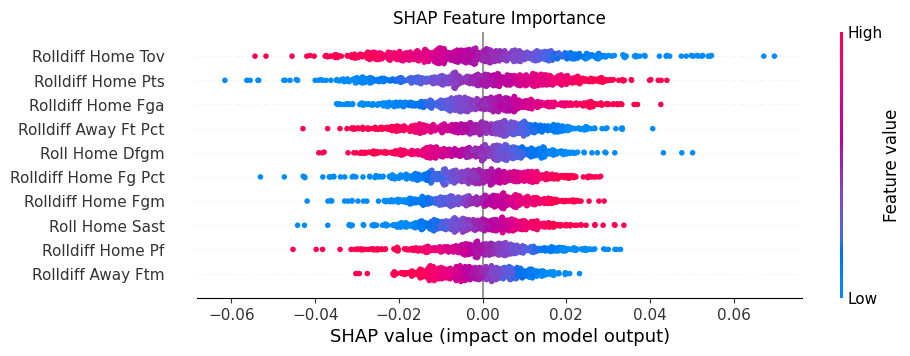

In [87]:
plot_shap_summary(model, res_all_features_test_set_renamed, n_features=10, figsize=(10, 3.5))

# LSTM Training

[Return to top](#Models)

## LSTM Data Preparation

In [15]:
all_features_df.head()

,GAME_ID,GAME_RESULT,TOTAL_PTS,PLUS_MINUS,HOME_TEAM_NAME,SEASON_ID,GAME_DATE,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,...,ROLL_AWAY_PASS,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT
0,22100002,0,235,-7.0,Los Angeles Lakers,2021-22,2021-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22100001,1,231,23.0,Milwaukee Bucks,2021-22,2021-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22100007,1,253,11.0,Memphis Grizzlies,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22100008,1,230,18.0,Minnesota Timberwolves,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22100009,0,214,-20.0,New Orleans Pelicans,2021-22,2021-10-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_lstm = all_features_df.dropna().copy()

In [17]:
df_lstm.head()

,GAME_ID,GAME_RESULT,TOTAL_PTS,PLUS_MINUS,HOME_TEAM_NAME,SEASON_ID,GAME_DATE,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,...,ROLL_AWAY_PASS,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT
27,22100031,1,185,7.0,Minnesota Timberwolves,2021-22,2021-10-23,124.0,42.0,87.0,...,281.0,19.0,40.0,0.475,23.0,47.0,0.489,20.0,24.0,0.833
28,22100029,0,198,-8.0,Toronto Raptors,2021-22,2021-10-23,83.0,30.0,97.0,...,279.0,9.0,33.0,0.273,22.0,60.0,0.367,12.0,20.0,0.600
29,22100033,1,239,29.0,Portland Trail Blazers,2021-22,2021-10-23,121.0,45.0,93.0,...,296.0,13.0,27.0,0.481,29.0,59.0,0.492,10.0,24.0,0.417
33,22100032,0,232,-10.0,San Antonio Spurs,2021-22,2021-10-23,123.0,49.0,98.0,...,263.0,15.0,28.0,0.536,17.0,56.0,0.304,18.0,22.0,0.818
36,22100037,0,204,-10.0,Houston Rockets,2021-22,2021-10-24,124.0,48.0,95.0,...,327.0,12.0,30.0,0.400,36.0,87.0,0.414,23.0,32.0,0.719


In [18]:
# get mapping for team IDs
unique_teams = pd.unique(df_lstm[['HOME_TEAM_NAME', 'AWAY_TEAM_NAME']].values.ravel('K'))
team_to_id = {team: i for i, team in enumerate(unique_teams)}

In [19]:
# create team IDs
df_lstm['home_team_id'] = df_lstm['HOME_TEAM_NAME'].map(team_to_id)
df_lstm['away_team_id'] = df_lstm['AWAY_TEAM_NAME'].map(team_to_id)

In [20]:
# check team IDs
print(df_lstm[['HOME_TEAM_NAME', 'home_team_id', 'AWAY_TEAM_NAME', 'away_team_id']].head(10))

            HOME_TEAM_NAME  home_team_id         AWAY_TEAM_NAME  away_team_id
27  Minnesota Timberwolves             0   New Orleans Pelicans            20
28         Toronto Raptors             1       Dallas Mavericks            22
29  Portland Trail Blazers             2           Phoenix Suns            17
33       San Antonio Spurs             3        Milwaukee Bucks            28
36         Houston Rockets             4         Boston Celtics            18
37      Los Angeles Lakers             5      Memphis Grizzlies            26
38         New York Knicks             6          Orlando Magic            16
39        Sacramento Kings             7  Golden State Warriors            24
41         Toronto Raptors             1          Chicago Bulls            21
42           Brooklyn Nets             8     Washington Wizards            25


In [21]:
def create_sequences_X(X, n_steps):
    """ Create sequences from dataset excluding target """
    Xs = []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:(i + n_steps)])  # Create sequence from i to i+n_steps-1
    return np.array(Xs)


def create_sequences_y(y, n_steps):
    """ Adjust target sequences to align with input sequences """
    return y[n_steps:]  # Offset by n_steps to align with inputs


def prepare_data_for_lstm_models(df, outcome_name, n_steps, num_test_samples, cols2drop):

    # drop unnecessary columns
    df = df.drop(cols2drop, axis=1)

    # Split the DataFrame into different inputs based on 'home' and 'away' prefixes
    team_id_columns = ['home_team_id', 'away_team_id']
    home_feature_columns = [col for col in df.columns if 'HOME_' in col and col != outcome_name]
    away_feature_columns = [col for col in df.columns if 'AWAY_' in col and col != outcome_name]

    # Extract team IDs
    home_team_ids = df['home_team_id'].values
    away_team_ids = df['away_team_id'].values

    # Extract features
    home_features = df[home_feature_columns].values
    away_features = df[away_feature_columns].values

    # Extract outcomes
    y = df[outcome_name].values

    # Split into training and test datasets
    index_train = slice(None, -num_test_samples)
    index_test = slice(-num_test_samples, None)

    datasets = {}
    for name, data in [('home_team_ids', home_team_ids), ('away_team_ids', away_team_ids),
                       ('home_features', home_features), ('away_features', away_features), ('y', y)]:
        datasets[f'{name}_train'] = data[index_train]
        datasets[f'{name}_test'] = data[index_test]

    # Scale the features
    scaler = MinMaxScaler()
    datasets['home_features_train'] = scaler.fit_transform(datasets['home_features_train'])
    datasets['home_features_test'] = scaler.transform(datasets['home_features_test'])
    datasets['away_features_train'] = scaler.fit_transform(datasets['away_features_train'])
    datasets['away_features_test'] = scaler.transform(datasets['away_features_test'])

    # Scale the outcome variable
    #target_scaler = MinMaxScaler()
    #y_train_scaled = target_scaler.fit_transform(datasets['y_train'].reshape(-1, 1))
    #y_test_scaled = target_scaler.transform(datasets['y_test'].reshape(-1, 1))

    # Check if the outcome variable is binary
    unique_values = np.unique(y)
    if len(unique_values) == 2 and np.all(np.isin(unique_values, [0, 1])):
        # If the outcome is binary (only contains 0 and 1), use it directly without scaling
        y_train_scaled = datasets['y_train'].reshape(-1, 1)
        y_test_scaled = datasets['y_test'].reshape(-1, 1)
        target_scaler = None  # No scaler used for binary outcomes
    else:
        # Scale the outcome variable for non-binary outcomes
        target_scaler = MinMaxScaler()
        y_train_scaled = target_scaler.fit_transform(datasets['y_train'].reshape(-1, 1))
        y_test_scaled = target_scaler.transform(datasets['y_test'].reshape(-1, 1))

    # Create sequences for all inputs and the output
    for key in datasets:
        if 'features' in key:
            datasets[key] = create_sequences_X(datasets[key], n_steps)
        elif 'team_ids' in key:
            datasets[key] = create_sequences_X(datasets[key].reshape(-1, 1), n_steps)

    y_train_seq = create_sequences_y(y_train_scaled, n_steps)
    y_test_seq = create_sequences_y(y_test_scaled, n_steps)

    return (datasets['home_team_ids_train'], datasets['away_team_ids_train'],
            datasets['home_features_train'], datasets['away_features_train'], y_train_seq,
            datasets['home_team_ids_test'], datasets['away_team_ids_test'],
            datasets['home_features_test'], datasets['away_features_test'], y_test_seq,
            target_scaler)

In [22]:
n_steps = 10 # number of sequence steps


cols2drop_pts = ['GAME_ID', 'GAME_RESULT', 'PLUS_MINUS', 'SEASON_ID',
                 'GAME_DATE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']

prepared_pts = prepare_data_for_lstm_models(
    df=df_lstm,
    outcome_name='TOTAL_PTS',
    n_steps=n_steps,
    num_test_samples=season_24_ngames,
    cols2drop=cols2drop_pts
    )


cols2drop_pm = ['GAME_ID', 'TOTAL_PTS', 'GAME_RESULT', 'SEASON_ID',
                 'GAME_DATE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']

prepared_pm = prepare_data_for_lstm_models(
    df=df_lstm,
    outcome_name='PLUS_MINUS',
    n_steps=n_steps,
    num_test_samples=season_24_ngames,
    cols2drop=cols2drop_pm
    )


cols2drop_res = ['GAME_ID', 'TOTAL_PTS', 'PLUS_MINUS', 'SEASON_ID',
                 'GAME_DATE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME']

prepared_res = prepare_data_for_lstm_models(
    df=df_lstm,
    outcome_name='GAME_RESULT',
    n_steps=n_steps,
    num_test_samples=season_24_ngames,
    cols2drop=cols2drop_res
    )

## Points Total

[Return to top](#Models)

In [23]:
# Define input shapes based on your data preparation
num_features_per_team = 124
embedding_dim = 5
num_teams = 30
sequence_length = n_steps # 10

# Inputs
home_team_input = Input(shape=(sequence_length, 1), name='home_team_id')
away_team_input = Input(shape=(sequence_length, 1), name='away_team_id')
home_features_input = Input(shape=(sequence_length, num_features_per_team), name='home_features')
away_features_input = Input(shape=(sequence_length, num_features_per_team), name='away_features')

# Embeddings for team IDs
team_embedding = Embedding(input_dim=num_teams, output_dim=embedding_dim, input_length=sequence_length)
home_team_embedding = team_embedding(home_team_input)
away_team_embedding = team_embedding(away_team_input)

# Reshape embeddings to remove unnecessary dimensions
home_team_embedding = Reshape((sequence_length, embedding_dim))(home_team_embedding)
away_team_embedding = Reshape((sequence_length, embedding_dim))(away_team_embedding)

# No need to flatten here; instead, concatenate along the feature axis (the last axis)
combined = Concatenate(axis=-1)([home_team_embedding, away_team_embedding, home_features_input, away_features_input])

# LSTM layer following the combined inputs
x = LSTM(units=64, return_sequences=False)(combined)
#x = Dropout(rate=0.1)(x)

# Additional LSTM Layer
#x = LSTM(units=32, return_sequences=False)(x)
#x = Dropout(rate=0.1)(x)

# Dense layer
#x = Dense(units=16, activation='linear')(x) # kernel_regularizer=l1(0.01)

# output
output = Dense(units=1, activation='linear')(x)

# Model
model = Model(inputs=[home_team_input, away_team_input, home_features_input, away_features_input], outputs=output)

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 home_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 away_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 embedding (Embedding)       (None, 10, 1, 5)             150       ['home_team_id[0][0]',        
                                                                     'away_team_id[0][0]']        
                                                                                                  
 reshape (Reshape)           (None, 10, 5)                0         ['embedding[0][0]']       

In [24]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='best_LSTM_pts.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

In [25]:
# compile
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [26]:
# unpack the data
(home_ids_train, away_ids_train, home_features_train, away_features_train, y_train,
 home_ids_test, away_ids_test, home_features_test, away_features_test, y_test, scaler) = prepared_pts

In [27]:
# train
history = model.fit(
    [home_ids_train, away_ids_train, home_features_train, away_features_train], # Inputs in the order they appear in the model
    y_train,  # Outputs
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/30
59/59 [==============================] - 3s 23ms/step - loss: 0.6079 - val_loss: 0.0134 - lr: 0.0100
Epoch 2/30
11/59 [====>.........................] - ETA: 0s - loss: 0.0120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 1s 13ms/step - loss: 0.0122 - val_loss: 0.0151 - lr: 0.0100
Epoch 3/30
59/59 [==============================] - 1s 17ms/step - loss: 0.0120 - val_loss: 0.0143 - lr: 0.0100
Epoch 4/30
59/59 [==============================] - 2s 28ms/step - loss: 0.0120 - val_loss: 0.0141 - lr: 0.0100
Epoch 5/30
59/59 [==============================] - 2s 26ms/step - loss: 0.0120 - val_loss: 0.0139 - lr: 0.0100
Epoch 6/30
59/59 [==============================] - 1s 23ms/step - loss: 0.0120 - val_loss: 0.0132 - lr: 0.0100
Epoch 7/30
59/59 [==============================] - 1s 12ms/step - loss: 0.0120 - val_loss: 0.0143 - lr: 0.0100
Epoch 8/30
59/59 [==============================] - 1s 13ms/step - loss: 0.0119 - val_loss: 0.0144 - lr: 0.0100
Epoch 9/30
59/59 [==============================] - 1s 13ms/step - loss: 0.0119 - val_loss: 0.0149 - lr: 0.0100
Epoch 10/30
59/59 [==============================] - 1s 13ms/step - loss: 0.0120 - val_loss: 0.0159 - lr: 0.0100
Ep

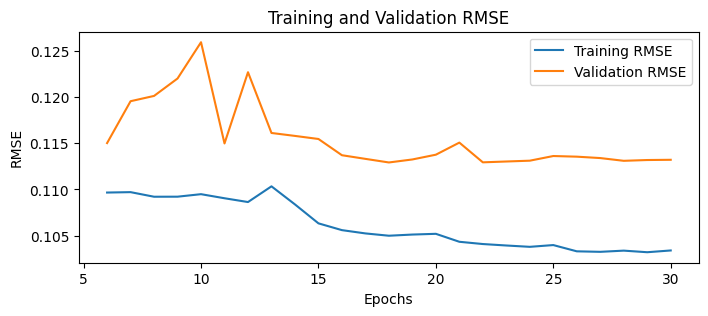

In [28]:
# Assume `history` is the object returned by `model.fit()`
mse = history.history['loss']
val_mse = history.history['val_loss']

# Calculate RMSE
rmse = np.sqrt(mse)
val_rmse = np.sqrt(val_mse)

epochs = range(1, len(rmse) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], rmse[5:], label='Training RMSE')
plt.plot(epochs[5:], val_rmse[5:], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [29]:
# Use the appropriate features from your test sets for prediction
test_predictions_norm = model.predict([home_ids_test, away_ids_test, home_features_test, away_features_test])

# Assuming scaler_pts was used to scale the target variable
test_predictions = scaler.inverse_transform(test_predictions_norm)  # Inverse transform predictions
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform true y values

rmse = mean_squared_error(y_test_original, test_predictions, squared=False)
print(f'RMSE on the original scale: {rmse:.2f}')

22/22 [==============================] - 0s 4ms/step
RMSE on the original scale: 20.86


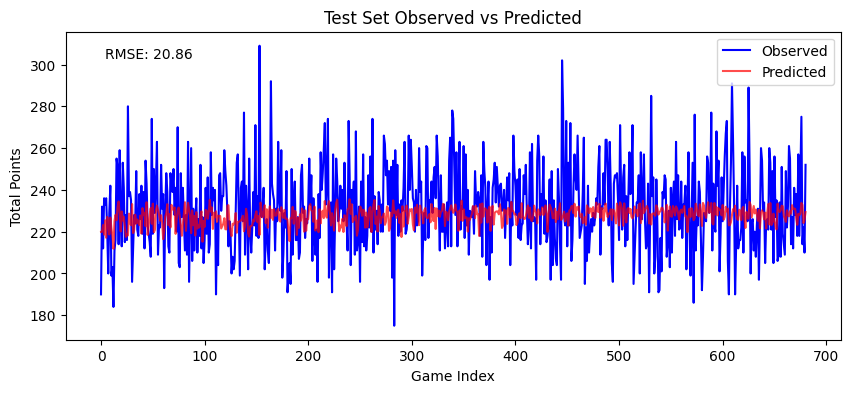

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_original, label='Observed', color='blue')
plt.plot(test_predictions.flatten(), label='Predicted', color='red', alpha=0.7)
plt.title('Test Set Observed vs Predicted')
plt.xlabel('Game Index')
plt.ylabel('Total Points')
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.legend(loc='upper right')
plt.show()

## Plus / Minus

[Return to top](#Models)

In [31]:
# Define input shapes based on your data preparation
num_features_per_team = 124
embedding_dim = 5
num_teams = 30
sequence_length = n_steps # 10

# Inputs
home_team_input = Input(shape=(sequence_length, 1), name='home_team_id')
away_team_input = Input(shape=(sequence_length, 1), name='away_team_id')
home_features_input = Input(shape=(sequence_length, num_features_per_team), name='home_features')
away_features_input = Input(shape=(sequence_length, num_features_per_team), name='away_features')

# Embeddings for team IDs
team_embedding = Embedding(input_dim=num_teams, output_dim=embedding_dim, input_length=sequence_length)
home_team_embedding = team_embedding(home_team_input)
away_team_embedding = team_embedding(away_team_input)

# Reshape embeddings to remove unnecessary dimensions
home_team_embedding = Reshape((sequence_length, embedding_dim))(home_team_embedding)
away_team_embedding = Reshape((sequence_length, embedding_dim))(away_team_embedding)

# No need to flatten here; instead, concatenate along the feature axis (the last axis)
combined = Concatenate(axis=-1)([home_team_embedding, away_team_embedding, home_features_input, away_features_input])

# LSTM layer following the combined inputs
x = LSTM(units=64, return_sequences=False)(combined)
#x = Dropout(rate=0.1)(x)

# Additional LSTM Layer
#x = LSTM(units=32, return_sequences=False)(x)
#x = Dropout(rate=0.1)(x)

# Dense layer
#x = Dense(units=16, activation='linear')(x) # kernel_regularizer=l1(0.01)

# output
output = Dense(units=1, activation='linear')(x)

# Model
model = Model(inputs=[home_team_input, away_team_input, home_features_input, away_features_input], outputs=output)

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 home_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 away_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 1, 5)             150       ['home_team_id[0][0]',        
                                                                     'away_team_id[0][0]']        
                                                                                                  
 reshape_2 (Reshape)         (None, 10, 5)                0         ['embedding_1[0][0]']   

In [32]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='best_LSTM_pm.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

In [33]:
# compile
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [34]:
# unpack the data
(home_ids_train, away_ids_train, home_features_train, away_features_train, y_train,
 home_ids_test, away_ids_test, home_features_test, away_features_test, y_test, scaler) = prepared_pm

In [35]:
# train
history = model.fit(
    [home_ids_train, away_ids_train, home_features_train, away_features_train], # Inputs in the order they appear in the model
    y_train,  # Outputs
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/30
59/59 [==============================] - 4s 30ms/step - loss: 0.4957 - val_loss: 0.0167 - lr: 0.0100
Epoch 2/30
 7/59 [==>...........................] - ETA: 1s - loss: 0.0154

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 2s 29ms/step - loss: 0.0130 - val_loss: 0.0124 - lr: 0.0100
Epoch 3/30
59/59 [==============================] - 1s 19ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0100
Epoch 4/30
59/59 [==============================] - 1s 13ms/step - loss: 0.0127 - val_loss: 0.0124 - lr: 0.0100
Epoch 5/30
59/59 [==============================] - 1s 14ms/step - loss: 0.0127 - val_loss: 0.0124 - lr: 0.0100
Epoch 6/30
59/59 [==============================] - 1s 24ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0100
Epoch 7/30
59/59 [==============================] - 2s 30ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0100
Epoch 8/30
59/59 [==============================] - 1s 23ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0100
Epoch 9/30
59/59 [==============================] - 1s 13ms/step - loss: 0.0127 - val_loss: 0.0125 - lr: 0.0100
Epoch 10/30
59/59 [==============================] - 1s 14ms/step - loss: 0.0126 - val_loss: 0.0124 - lr: 0.0020
Ep

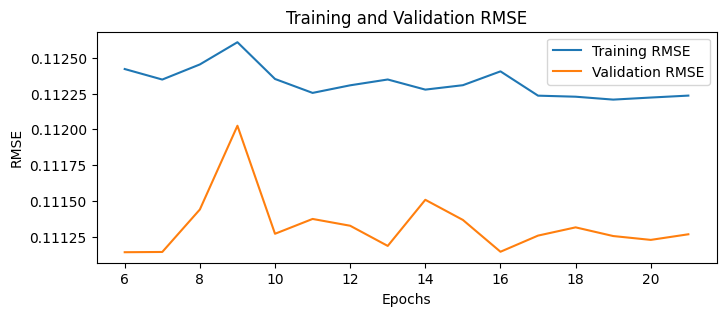

In [36]:
# Assume `history` is the object returned by `model.fit()`
mse = history.history['loss']
val_mse = history.history['val_loss']

# Calculate RMSE
rmse = np.sqrt(mse)
val_rmse = np.sqrt(val_mse)

epochs = range(1, len(rmse) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], rmse[5:], label='Training RMSE')
plt.plot(epochs[5:], val_rmse[5:], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [38]:
# Use the appropriate features from your test sets for prediction
test_predictions_norm = model.predict([home_ids_test, away_ids_test, home_features_test, away_features_test])

# Assuming scaler_pts was used to scale the target variable
test_predictions = scaler.inverse_transform(test_predictions_norm)  # Inverse transform predictions
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform true y values

rmse = mean_squared_error(y_test_original, test_predictions, squared=False)
print(f'RMSE on the original scale: {rmse:.2f}')

22/22 [==============================] - 0s 9ms/step
RMSE on the original scale: 15.37


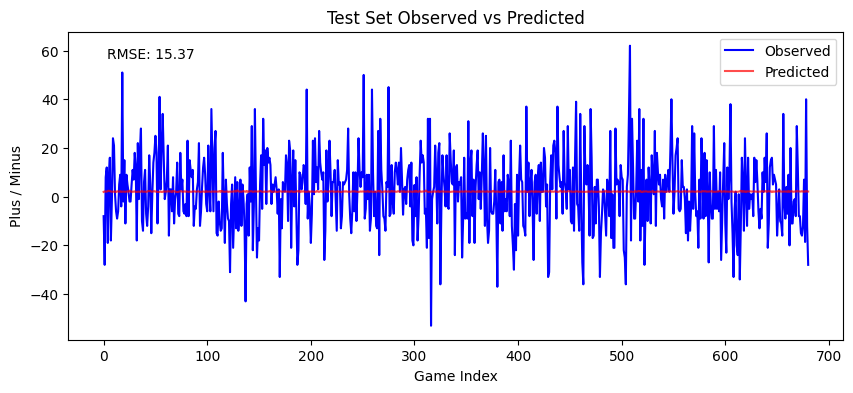

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_original, label='Observed', color='blue')
plt.plot(test_predictions.flatten(), label='Predicted', color='red', alpha=0.7)
plt.title('Test Set Observed vs Predicted')
plt.xlabel('Game Index')
plt.ylabel('Plus / Minus')
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.legend()
plt.show()

## Game Winner

[Return to top](#Models)

In [40]:
# Define input shapes based on your data preparation
num_features_per_team = 124
embedding_dim = 5
num_teams = 30
sequence_length = n_steps # 10

# Inputs
home_team_input = Input(shape=(sequence_length, 1), name='home_team_id')
away_team_input = Input(shape=(sequence_length, 1), name='away_team_id')
home_features_input = Input(shape=(sequence_length, num_features_per_team), name='home_features')
away_features_input = Input(shape=(sequence_length, num_features_per_team), name='away_features')

# Embeddings for team IDs
team_embedding = Embedding(input_dim=num_teams, output_dim=embedding_dim, input_length=sequence_length)
home_team_embedding = team_embedding(home_team_input)
away_team_embedding = team_embedding(away_team_input)

# Reshape embeddings to remove unnecessary dimensions
home_team_embedding = Reshape((sequence_length, embedding_dim))(home_team_embedding)
away_team_embedding = Reshape((sequence_length, embedding_dim))(away_team_embedding)

# No need to flatten here; instead, concatenate along the feature axis (the last axis)
combined = Concatenate(axis=-1)([home_team_embedding, away_team_embedding, home_features_input, away_features_input])

# LSTM layer following the combined inputs
x = LSTM(units=64, return_sequences=False)(combined)
#x = Dropout(rate=0.1)(x)

# Additional LSTM Layer
#x = LSTM(units=32, return_sequences=False)(x)
#x = Dropout(rate=0.1)(x)

# Dense layer
#x = Dense(units=16, activation='relu')(x) # kernel_regularizer=l1(0.01)

# output
output = Dense(units=1, activation='sigmoid')(x)

# Model
model = Model(inputs=[home_team_input, away_team_input, home_features_input, away_features_input], outputs=output)

# Model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 home_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 away_team_id (InputLayer)   [(None, 10, 1)]              0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 10, 1, 5)             150       ['home_team_id[0][0]',        
                                                                     'away_team_id[0][0]']        
                                                                                                  
 reshape_4 (Reshape)         (None, 10, 5)                0         ['embedding_2[0][0]']   

In [41]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(filepath='best_LSTM_res.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

In [42]:
# compile
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')

In [43]:
# unpack the data
(home_ids_train, away_ids_train, home_features_train, away_features_train, y_train,
 home_ids_test, away_ids_test, home_features_test, away_features_test, y_test, scaler) = prepared_res

In [44]:
# train
history = model.fit(
    [home_ids_train, away_ids_train, home_features_train, away_features_train], # Inputs in the order they appear in the model
    y_train,  # Outputs
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/30
59/59 [==============================] - 4s 21ms/step - loss: 0.7085 - val_loss: 0.6892 - lr: 0.0100
Epoch 2/30
11/59 [====>.........................] - ETA: 0s - loss: 0.6890

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 1s 13ms/step - loss: 0.6854 - val_loss: 0.6894 - lr: 0.0100
Epoch 3/30
59/59 [==============================] - 1s 13ms/step - loss: 0.6848 - val_loss: 0.6909 - lr: 0.0100
Epoch 4/30
59/59 [==============================] - 1s 13ms/step - loss: 0.6825 - val_loss: 0.6901 - lr: 0.0100
Epoch 5/30
59/59 [==============================] - 1s 20ms/step - loss: 0.6822 - val_loss: 0.6887 - lr: 0.0100
Epoch 6/30
59/59 [==============================] - 2s 29ms/step - loss: 0.6798 - val_loss: 0.6891 - lr: 0.0100
Epoch 7/30
59/59 [==============================] - 1s 25ms/step - loss: 0.6776 - val_loss: 0.7010 - lr: 0.0100
Epoch 8/30
59/59 [==============================] - 1s 13ms/step - loss: 0.6740 - val_loss: 0.6983 - lr: 0.0100
Epoch 9/30
59/59 [==============================] - 1s 12ms/step - loss: 0.6750 - val_loss: 0.7112 - lr: 0.0100
Epoch 10/30
59/59 [==============================] - 1s 13ms/step - loss: 0.6735 - val_loss: 0.7048 - lr: 0.0100
Ep

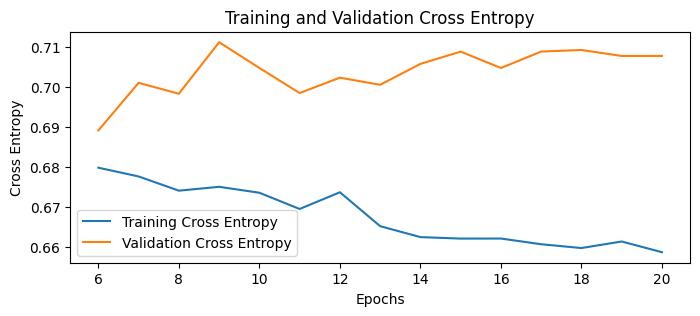

In [45]:
# Assume `history` is the object returned by `model.fit()`
xent = history.history['loss']
val_xent = history.history['val_loss']

epochs = range(1, len(xent) + 1)

plt.figure(figsize=(8, 3))
plt.plot(epochs[5:], xent[5:], label='Training Cross Entropy')
plt.plot(epochs[5:], val_xent[5:], label='Validation Cross Entropy')
plt.title('Training and Validation Cross Entropy')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [46]:
# Use the appropriate features from your test sets for prediction
test_predictions_probs = model.predict([home_ids_test, away_ids_test, home_features_test, away_features_test])

# binary predictions
binary_predictions = np.where(test_predictions_probs > 0.5, 1, 0)

# Accuracy
acc = accuracy_score(y_test, binary_predictions)
print(f'Accuracy: {acc:.2f}')

# F1-score
f1 = f1_score(y_test, binary_predictions)
print(f'F1 Score: {f1:.2f}')

22/22 [==============================] - 1s 5ms/step
Accuracy: 0.55
F1 Score: 0.66


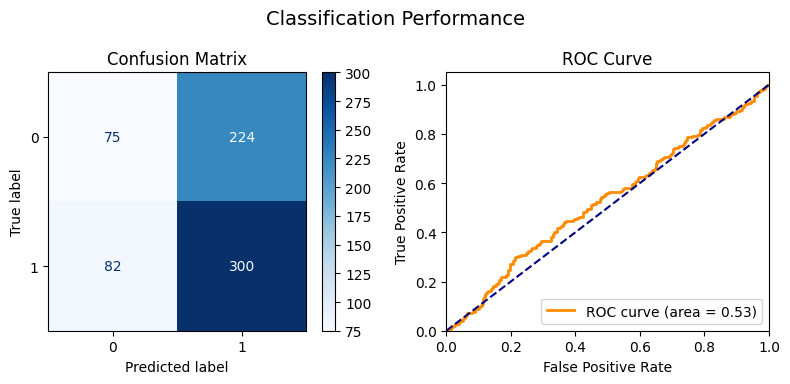

In [47]:
utl.plot_classification_performance(y_test, test_predictions_probs, binary_predictions)